In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt


# Downloads CIFAR-10 automatically and loads it into memory
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 784s 5us/step


In [77]:
from skimage import io, util

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

Train: (50000, 32, 32, 3) (50000, 1)
Test: (10000, 32, 32, 3) (10000, 1)


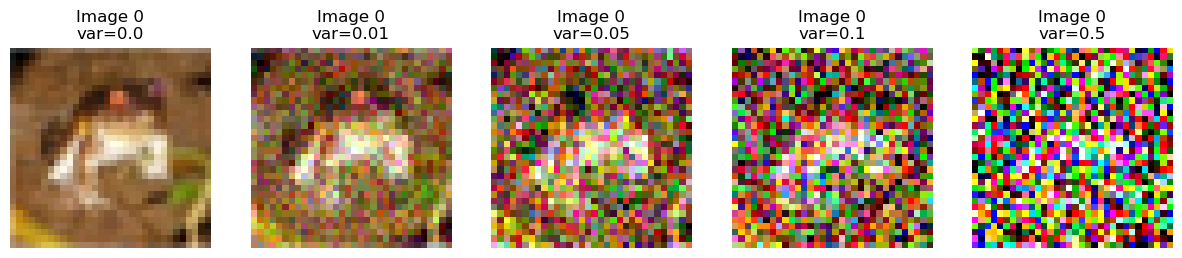

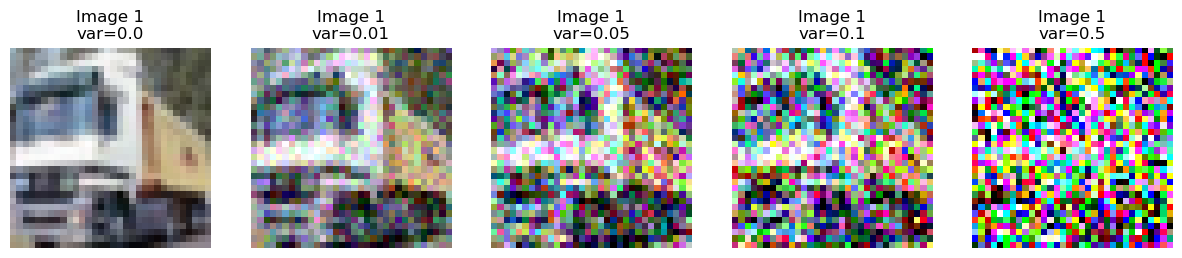

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, util

# Variances for Gaussian noise
variances = [0, 0.01, 0.05, 0.1, 0.5]

# Store results
results = []

for var in variances:
    noisy0 = util.random_noise(x_train[0], mode='gaussian', var=var)
    noisy1 = util.random_noise(x_train[1], mode='gaussian', var=var)
    
    # Save images
    fname0 = f"noisy0_{var}.jpg"
    fname1 = f"noisy1_{var}.jpg"
    io.imsave(fname0, (noisy0 * 255).astype("uint8"))
    io.imsave(fname1, (noisy1 * 255).astype("uint8"))
    
    # Append metadata for DataFrame
    results.append({"Image": "img0", "Variance": var, "Path": fname0, "Array": noisy0})
    results.append({"Image": "img1", "Variance": var, "Path": fname1, "Array": noisy1})

# Convert to DataFrame
df = pd.DataFrame(results)

# Pretty grid visualization
def show_noisy_grid(img_results, title_prefix="Image"):
    fig, axes = plt.subplots(1, len(img_results), figsize=(15, 3))
    for ax, row in zip(axes, img_results):
        ax.imshow(row["Array"])
        ax.set_title(f"{title_prefix}\nvar={row['Variance']}")
        ax.axis("off")
    plt.show()

# Show both grids
show_noisy_grid(df[df["Image"] == "img0"].to_dict("records"), "Image 0")
show_noisy_grid(df[df["Image"] == "img1"].to_dict("records"), "Image 1")



,Image,Variance,BRISQUE
0,img0,0.00,22.565944
1,img0,0.01,34.455885
2,img0,0.05,94.458629
3,img0,0.10,91.291314
4,img0,0.50,82.571174
5,img1,0.00,68.056073
6,img1,0.01,39.243994
7,img1,0.05,129.582771
8,img1,0.10,85.285124
9,img1,0.50,112.613810


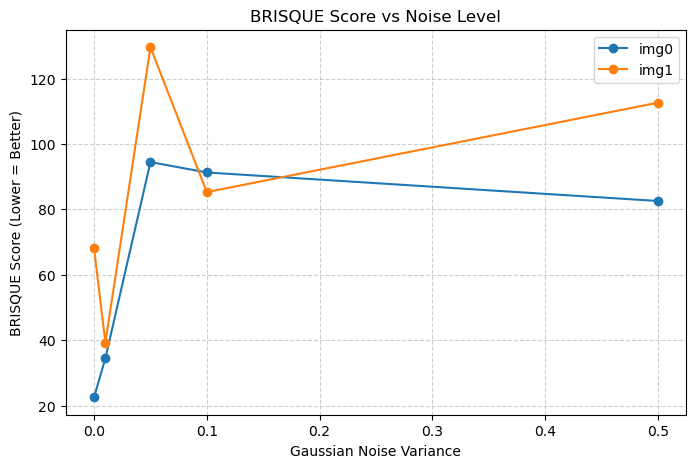

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from brisque import BRISQUE
import cv2

# Create BRISQUE object
brisque = BRISQUE()

# File lists
var = ['noisy0_0.jpg', 'noisy0_0.01.jpg', 'noisy0_0.05.jpg', 'noisy0_0.1.jpg', 'noisy0_0.5.jpg']
var1 = ['noisy1_0.jpg', 'noisy1_0.01.jpg', 'noisy1_0.05.jpg', 'noisy1_0.1.jpg', 'noisy1_0.5.jpg']

results = []

# Process first image set
for fname in var:
    img = cv2.imread(fname)
    score = brisque.score(img)
    variance = float(fname.split("_")[-1].replace(".jpg", ""))  # Extract variance
    results.append({"Image": "img0", "Variance": variance, "BRISQUE": score})

# Process second image set
for fname in var1:
    img = cv2.imread(fname)
    score = brisque.score(img)
    variance = float(fname.split("_")[-1].replace(".jpg", ""))  # Extract variance
    results.append({"Image": "img1", "Variance": variance, "BRISQUE": score})

# Convert to DataFrame
df_scores = pd.DataFrame(results).sort_values(by=["Image", "Variance"])

display(df_scores)

# Plot results
plt.figure(figsize=(8, 5))
for img_id, group in df_scores.groupby("Image"):
    plt.plot(group["Variance"], group["BRISQUE"], marker="o", label=img_id)

plt.xlabel("Gaussian Noise Variance")
plt.ylabel("BRISQUE Score (Lower = Better)")
plt.title("BRISQUE Score vs Noise Level")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
